In [1]:
# Basic packages
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import math
import netCDF4 as nc

# DateTime packages
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta
import time
import matplotlib.dates as mdates

# Stats packages
import scipy
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import seaborn as sns

# Logistical packages
import requests
from importlib import reload
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pyleoclim as pyleo

# Data

In [5]:
df = pd.read_csv('/Users/akbaskind/Desktop/Paleo/ODP846_corr.XRFdata_with age.csv')
df.keys()

Index(['Depth (mcd)', 'mcd (Lawrence)', 'age (ka)', 'MnO', 'Fe2O3', 'TiO2',
       'CaCO3', 'Al2O3', 'SiO2', 'BaSO4', 'Unnamed: 10', 'age_846', 'SST_846',
       'Unnamed: 13', 'Unnamed: 14', 'kyr BP', 'mcd'],
      dtype='object')

In [8]:
LRCE = df[['Depth (mcd)', 'mcd (Lawrence)', 'age (ka)', 'MnO', 'Fe2O3', 'TiO2',
       'CaCO3', 'Al2O3', 'SiO2', 'BaSO4']]
SST = df[['age_846', 'SST_846']].dropna()
tie = df[['kyr BP', 'mcd']].dropna()

In [77]:
CACO3 = LRCE[['age (ka)', 'CaCO3']].dropna()
FE2O3 = LRCE[['age (ka)', 'Fe2O3']].dropna()
FE2O3

age (ka)  Fe2O3
0       32.525688  1.188
1       32.779401  1.229
2       33.286827  1.186
3       33.794253  1.150
4       34.301680  1.114
...           ...    ...
8525  4607.598522  0.428
8526  4608.105773  0.424
8527  4608.613025  0.380
8528  4609.120273  0.378
8529  4609.627524  0.514

[8530 rows x 2 columns]

# Age v SST, CaCO3, & Fe2O3

Text(0.5, 0.98, 'Time series (raw data)')

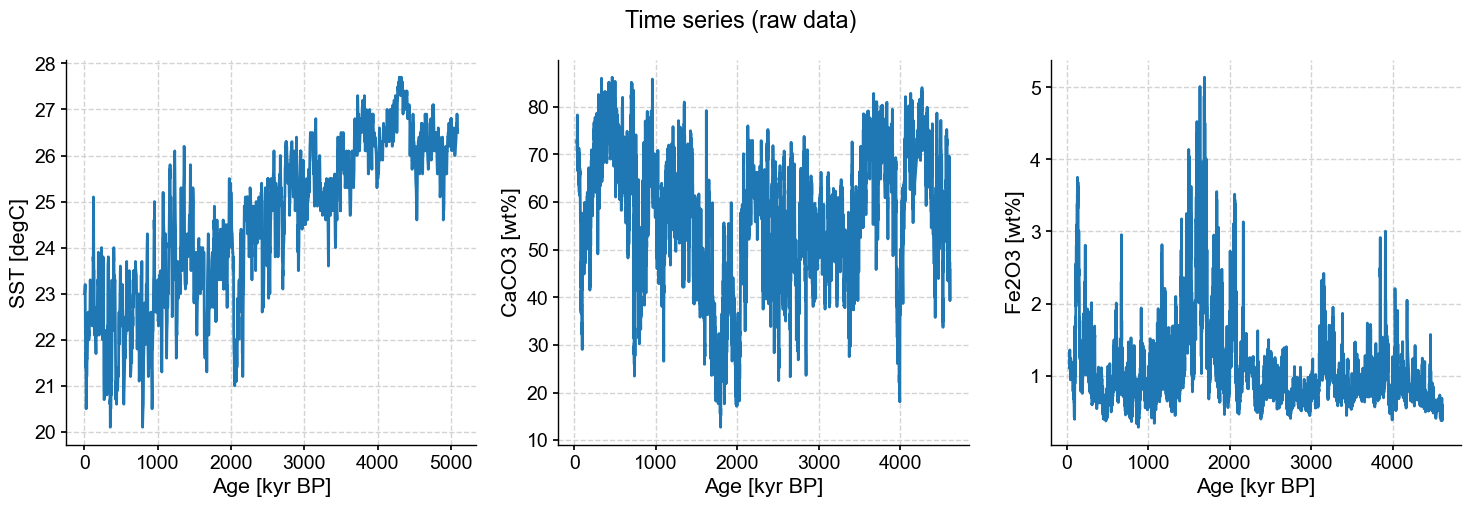

In [134]:
fig,axarr = plt.subplots(ncols = 3, figsize = [18,5])
axarr = axarr.flatten()

# SST
ax = axarr[0]
ax.plot(SST['age_846'], SST['SST_846'])
ax.set_xlabel('Age [kyr BP]')
ax.set_ylabel('SST [degC]')

# CaCO3
ax = axarr[1]
ax.plot(CACO3['age (ka)'], CACO3['CaCO3'])
ax.set_xlabel('Age [kyr BP]')
ax.set_ylabel('CaCO3 [wt%]')

# Fe2O3
ax = axarr[2]
ax.plot(FE2O3['age (ka)'], FE2O3['Fe2O3'])
ax.set_xlabel('Age [kyr BP]')
ax.set_ylabel('Fe2O3 [wt%]')

fig.suptitle('Time series (raw data)')

# Bin
## SST bins

In [84]:
bins = np.arange(SST['age_846'].min(),SST['age_846'].max(),2.5)

SSTbin = SST.groupby(pd.cut(SST['age_846'], bins=bins)).mean().dropna()
SSTbin

age_846  SST_846
age_846                                  
(7.728, 10.228]          8.94700    23.10
(10.228, 12.728]        11.96600    23.20
(12.728, 15.228]        14.42700    22.00
(15.228, 17.728]        16.50200    21.70
(17.728, 20.228]        19.19285    21.55
...                          ...      ...
(5067.728, 5070.228]  5069.34500    26.40
(5072.728, 5075.228]  5073.19100    26.70
(5075.228, 5077.728]  5077.03200    26.50
(5080.228, 5082.728]  5080.88000    26.90
(5082.728, 5085.228]  5085.15400    26.60

[1732 rows x 2 columns]

## CaCO3 bins

In [86]:
bins = np.arange(CACO3['age (ka)'].min(),CACO3['age (ka)'].max(),0.5)

CaCO3bin = CACO3.groupby(pd.cut(CACO3['age (ka)'], bins=bins)).mean().dropna()
CaCO3bin

age (ka)   CaCO3
age (ka)                                 
(32.526, 33.026]        32.779401  72.322
(33.026, 33.526]        33.286827  73.119
(33.526, 34.026]        33.794253  72.287
(34.026, 34.526]        34.301680  72.309
(34.526, 35.026]        34.809106  74.039
...                           ...     ...
(4606.526, 4607.026]  4606.837650  44.131
(4607.526, 4608.026]  4607.598522  44.352
(4608.026, 4608.526]  4608.105773  43.022
(4608.526, 4609.026]  4608.613025  40.357
(4609.026, 4609.526]  4609.120273  39.307

[7414 rows x 2 columns]

## Fe2O3 bins

In [87]:
bins = np.arange(FE2O3['age (ka)'].min(),FE2O3['age (ka)'].max(),0.5)

Fe2O3bin = FE2O3.groupby(pd.cut(FE2O3['age (ka)'], bins=bins)).mean().dropna()
Fe2O3bin

age (ka)  Fe2O3
age (ka)                                
(32.526, 33.026]        32.779401  1.229
(33.026, 33.526]        33.286827  1.186
(33.526, 34.026]        33.794253  1.150
(34.026, 34.526]        34.301680  1.114
(34.526, 35.026]        34.809106  1.169
...                           ...    ...
(4606.526, 4607.026]  4606.837650  0.462
(4607.526, 4608.026]  4607.598522  0.428
(4608.026, 4608.526]  4608.105773  0.424
(4608.526, 4609.026]  4608.613025  0.380
(4609.026, 4609.526]  4609.120273  0.378

[7414 rows x 2 columns]

# Make pyleo object

In [39]:
SST_pyleo = pyleo.Series(time=SST['age_846'], value=SST['SST_846'],
                      time_name='Age', time_unit='ka', verbose=False,
                      value_name='SST', value_unit='°C')
SSTbin_pyleo = pyleo.Series(time=SSTbin['age_846'], value=SSTbin['SST_846'],
                      time_name='Age', time_unit='ka', verbose=False,
                      value_name='SST', value_unit='°C')
SSTbin_pyleo

{}


None
Age [ka]
8.94700       23.10
11.96600      23.20
14.42700      22.00
16.50200      21.70
19.19285      21.55
              ...  
5069.34500    26.40
5073.19100    26.70
5077.03200    26.50
5080.88000    26.90
5085.15400    26.60
Name: SST [°C], Length: 1732, dtype: float64

In [88]:
Ca_pyleo = pyleo.Series(time=CACO3['age (ka)'], value=CACO3['CaCO3'],
                      time_name='Age', time_unit='ka', verbose=False,
                      value_name='CaCO3', value_unit='wt%')
Cabin_pyleo = pyleo.Series(time=CaCO3bin['age (ka)'], value=CaCO3bin['CaCO3'],
                      time_name='Age', time_unit='ka', verbose=False,
                      value_name='CaCO3', value_unit='wt%')
Cabin_pyleo

{}


None
Age [ka]
32.779401      72.322
33.286827      73.119
33.794253      72.287
34.301680      72.309
34.809106      74.039
                ...  
4606.837650    44.131
4607.598522    44.352
4608.105773    43.022
4608.613025    40.357
4609.120273    39.307
Name: CaCO3 [wt%], Length: 7414, dtype: float64

In [89]:
Fe_pyleo = pyleo.Series(time=FE2O3['age (ka)'], value=FE2O3['Fe2O3'],
                      time_name='Age', time_unit='ka', verbose=False,
                      value_name='Fe2O3', value_unit='wt%')
Febin_pyleo = pyleo.Series(time=Fe2O3bin['age (ka)'], value=Fe2O3bin['Fe2O3'],
                      time_name='Age', time_unit='ka', verbose=False,
                      value_name='Fe2O3', value_unit='wt%')
Febin_pyleo

{}


None
Age [ka]
32.779401      1.229
33.286827      1.186
33.794253      1.150
34.301680      1.114
34.809106      1.169
               ...  
4606.837650    0.462
4607.598522    0.428
4608.105773    0.424
4608.613025    0.380
4609.120273    0.378
Name: Fe2O3 [wt%], Length: 7414, dtype: float64

# Bin v Unbinned data

Text(0.5, 0.98, 'Comparison of binned vs unbinned data')

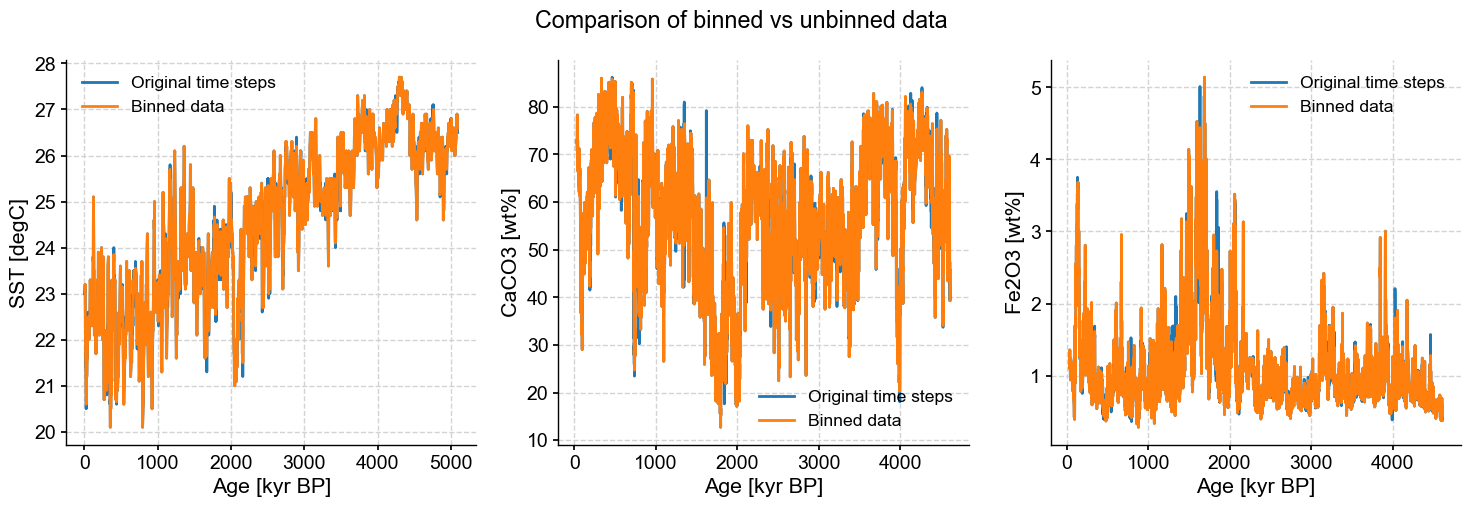

In [135]:
fig,axarr = plt.subplots(ncols = 3, figsize = [18,5])
axarr = axarr.flatten()

# SST
ax = axarr[0]
ax.plot(SST['age_846'], SST['SST_846'], label = 'Original time steps')
ax.plot(SSTbin['age_846'], SSTbin['SST_846'], label = 'Binned data')
ax.set_xlabel('Age [kyr BP]')
ax.set_ylabel('SST [degC]')
ax.legend()

# CaCO3
ax = axarr[1]
ax.plot(CACO3['age (ka)'], CACO3['CaCO3'], label = 'Original time steps')
ax.plot(CaCO3bin['age (ka)'], CaCO3bin['CaCO3'], label = 'Binned data')
ax.set_xlabel('Age [kyr BP]')
ax.set_ylabel('CaCO3 [wt%]')
ax.legend()

# Fe2O3
ax = axarr[2]
ax.plot(FE2O3['age (ka)'], FE2O3['Fe2O3'], label = 'Original time steps')
ax.plot(Fe2O3bin['age (ka)'], Fe2O3bin['Fe2O3'], label = 'Binned data')
ax.set_xlabel('Age [kyr BP]')
ax.set_ylabel('Fe2O3 [wt%]')
ax.legend()

fig.suptitle('Comparison of binned vs unbinned data')

Text(0.5, 1.0, 'Binned Fe2O3 data')

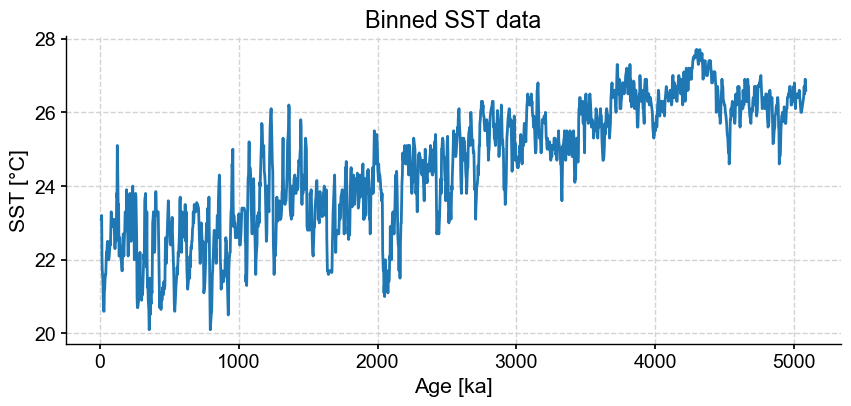

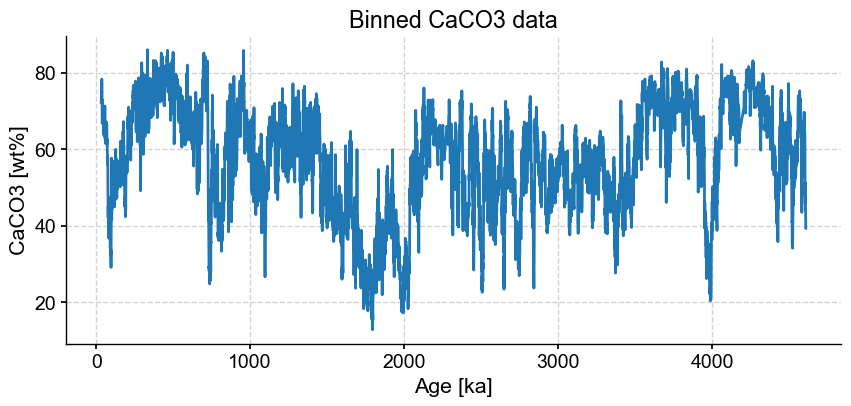

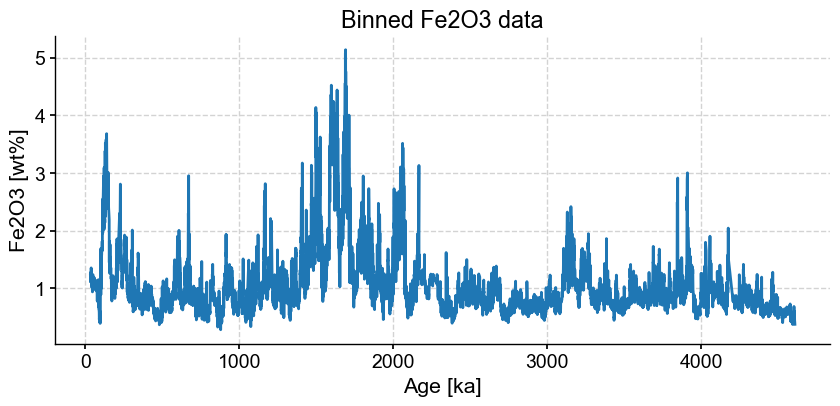

In [137]:
fig, ax = SSTbin_pyleo.plot()
ax.set_title('Binned SST data')

fig, ax = Cabin_pyleo.plot()
ax.set_title('Binned CaCO3 data')

fig, ax = Febin_pyleo.plot()
ax.set_title('Binned Fe2O3 data')

# Detrend binned data
## SST
Detrending changes the shape of the time series for SST.

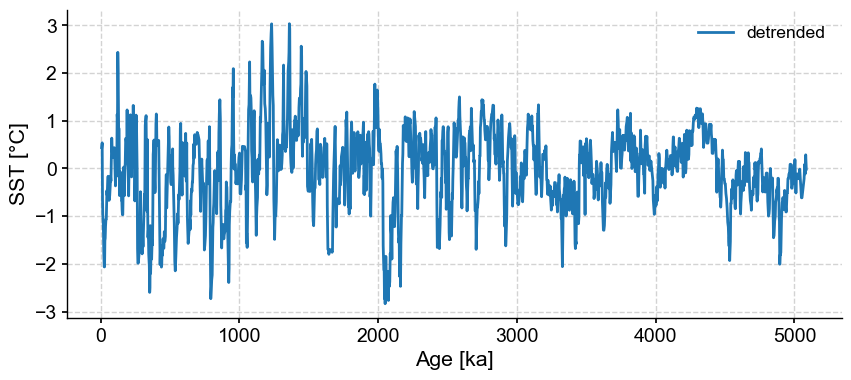

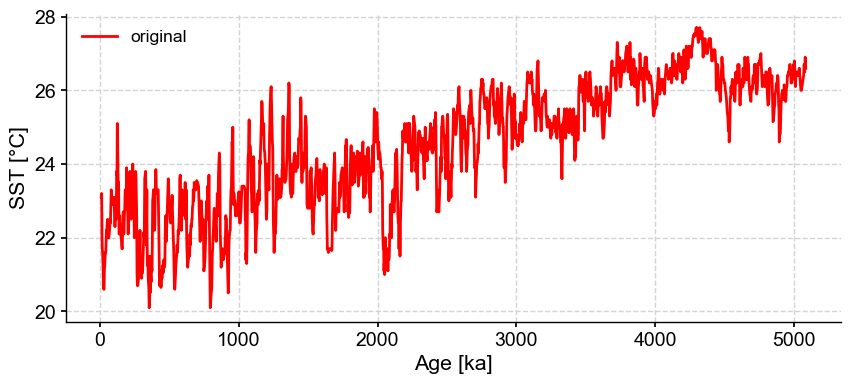

In [52]:
SSTbin_detrend = SSTbin_pyleo.detrend(method = 'emd')
fig, ax = SSTbin_detrend.plot(label = 'detrended')

fig,ax = SSTbin_pyleo.plot(color = 'red', label = 'original')


## CacO3
The shape of the time series doesn't change the same way SST does.

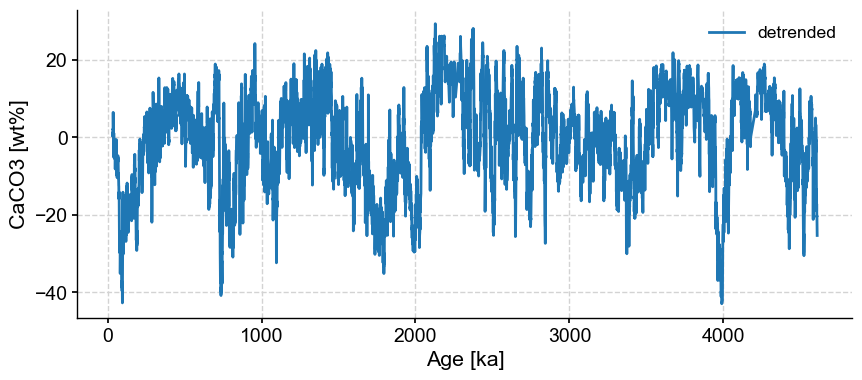

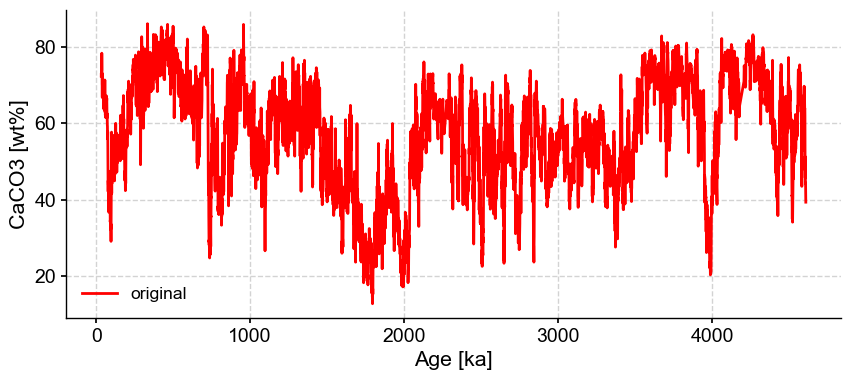

In [92]:
Cabin_detrend = Cabin_pyleo.detrend(method = 'emd')
fig, ax = Cabin_detrend.plot(label = 'detrended')

fig,ax = Cabin_pyleo.plot(color = 'red', label = 'original')

## Fe2O3

Once again the shape of the time series doesn't really change.

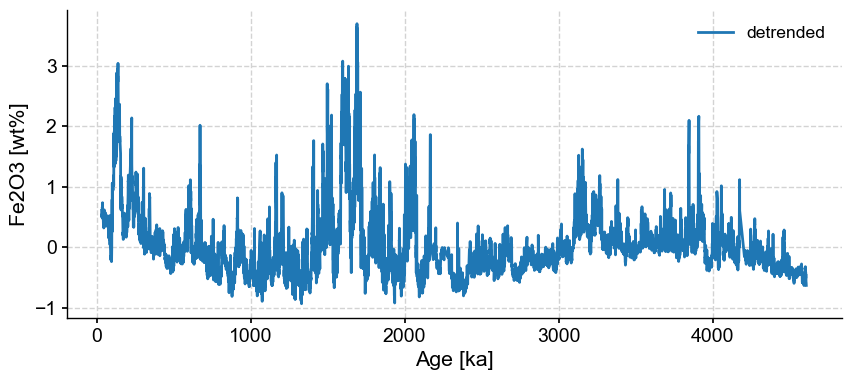

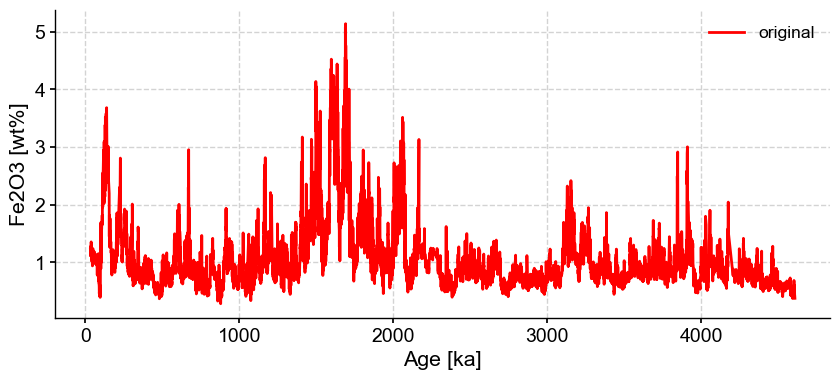

In [93]:
Febin_detrend = Febin_pyleo.detrend(method = 'emd')
fig, ax = Febin_detrend.plot(label = 'detrended')

fig,ax = Febin_pyleo.plot(color = 'red', label = 'original')

# SST Spectral Analysis
## Periodogram
### Comments

The original (not detrended) data and detrended data show similar PSD for periods shorter than 200 kyr, except for Blackman Harris windowing. For Blackman Harris windowing, original data shows a slightly lower PSD than the detrended data. It seems that detrending preserves signals that occur on Milankovitch-type timescales. 

The PSDs for original and detrended data begin to diverge for longer periods, especially longer than 500 kyr. Differences seem to be most extreme using Bartlett windowing. In this method, the original data shows a PSD minimum at 1000 kyr that is entirely absent from the detrended data. It seems that detrending influences PSD variatons across methods more as periods get longer. I am unsure what processes operate on such long timescale, so it is difficult to say what these differing signals mean. But the great variation across methods suggests we cannot overinterpret these long period signals.

For both original and detrended data across all methods, there is a local maximum in PSD around the 40kyr mark. Other notable orbitally driven periodicities are not as obvious.

Text(0.5, 1.0, 'SST Periodogram: Bartlett Windows')

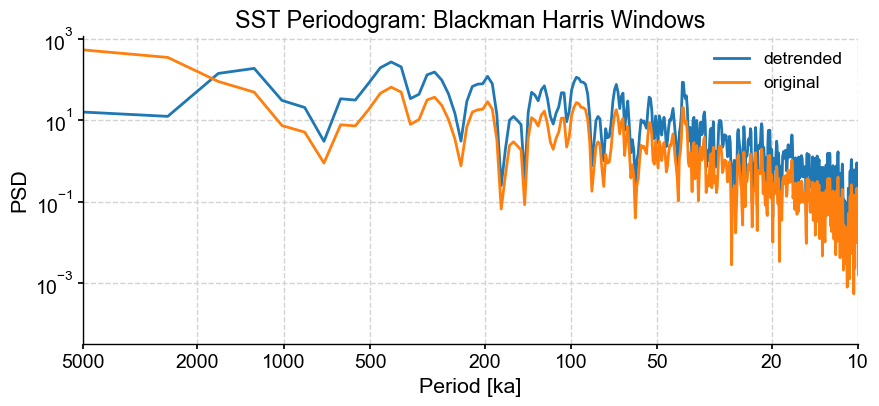

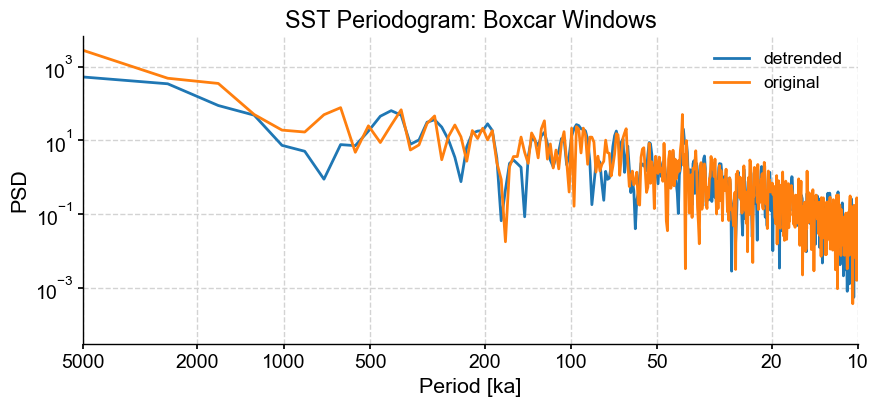

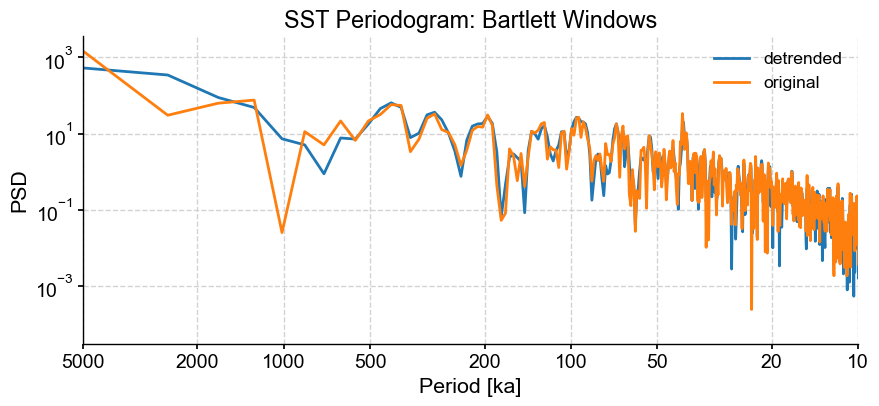

In [138]:
PSD = SSTbin_detrend.standardize().interp().spectral(method='periodogram', settings={'window':'blackmanharris'})
fig,ax = PSD.plot(label = 'detrended')
PSD = SSTbin_pyleo.standardize().interp().spectral(method='periodogram', settings={'window':'blackmanharris'})
PSD.plot(ax = ax, label = 'original')
ax.set_title('SST Periodogram: Blackman Harris Windows')

PSD = SSTbin_detrend.standardize().interp().spectral(method='periodogram', settings={'window':'boxcar'})
fig,ax = PSD_boxcar.plot(label = 'detrended')
PSD = SSTbin_pyleo.standardize().interp().spectral(method='periodogram', settings={'window':'boxcar'})
PSD.plot(ax = ax, label = 'original')
ax.set_title('SST Periodogram: Boxcar Windows')

PSD = SSTbin_detrend.standardize().interp().spectral(method='periodogram', settings={'window':'bartlett'})
fig,ax = PSD_boxcar.plot(label = 'detrended')
PSD = SSTbin_pyleo.standardize().interp().spectral(method='periodogram', settings={'window':'bartlett'})
PSD.plot(ax = ax, label = 'original')
ax.set_title('SST Periodogram: Bartlett Windows')


Text(0.5, 1.0, 'SST Periodogram Not detrended')

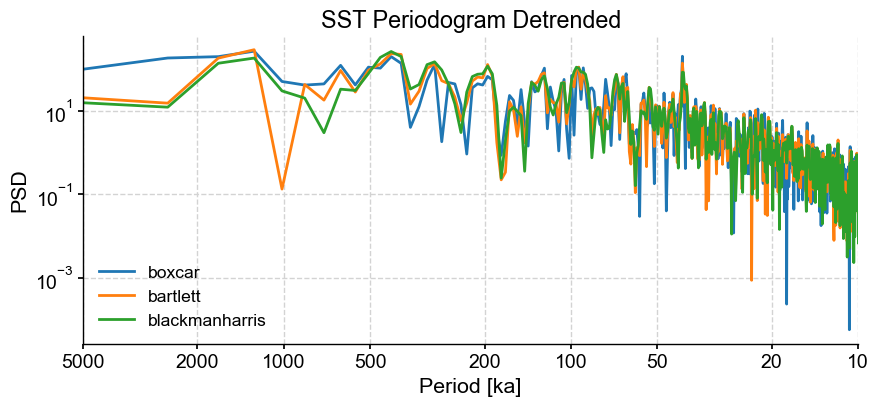

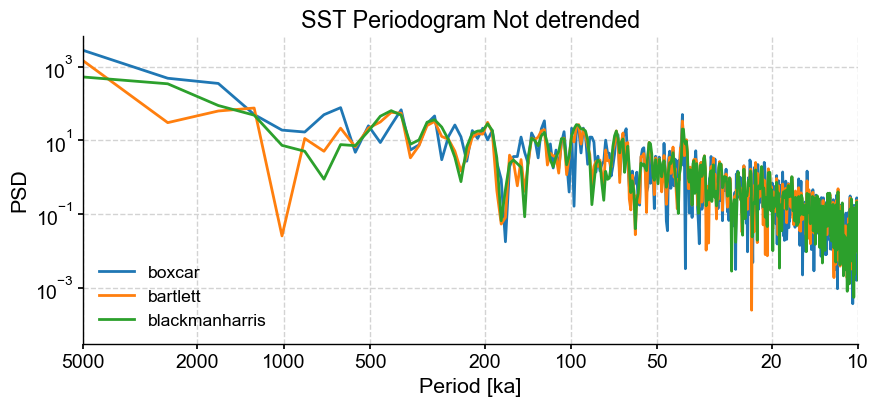

In [139]:
PSD_boxcar = SSTbin_detrend.standardize().interp().spectral(method='periodogram', settings={'window':'boxcar'})
fig,ax = PSD_boxcar.plot(label = 'boxcar')
SSTbin_detrend.standardize().interp().spectral(method='periodogram', settings={'window':'bartlett'}).plot(ax=ax,label='bartlett')
SSTbin_detrend.standardize().interp().spectral(method='periodogram', settings={'window':'blackmanharris'}).plot(ax=ax,label='blackmanharris')
ax.set_title('SST Periodogram Detrended')

PSD_boxcar = SSTbin_pyleo.standardize().interp().spectral(method='periodogram', settings={'window':'boxcar'})
fig,ax = PSD_boxcar.plot(label = 'boxcar')
SSTbin_pyleo.standardize().interp().spectral(method='periodogram', settings={'window':'bartlett'}).plot(ax=ax,label='bartlett')
SSTbin_pyleo.standardize().interp().spectral(method='periodogram', settings={'window':'blackmanharris'}).plot(ax=ax,label='blackmanharris')
ax.set_title('SST Periodogram Not detrended')

## Welch
### Comments
Regardless of segmenting using the Welch method, nearly all periods (except very long periods) show high PSD for the detrended data. Personally, I would expect as much, since detrending is removing some amount of long-term variation. Increasing the segments (e.g. from 3 to 5) smooths the data, and at least for this data for shorter periods enables greater visibility of certain orbitally driven periodicities, especially around 100kyr and 40kyr. Again a 20kyr signal is not particularly noticeable.

I could not see much of a difference between 4 segments and 5 segments.

Text(0.5, 1.0, 'SST: Welch 5 segments, 50% overlap')

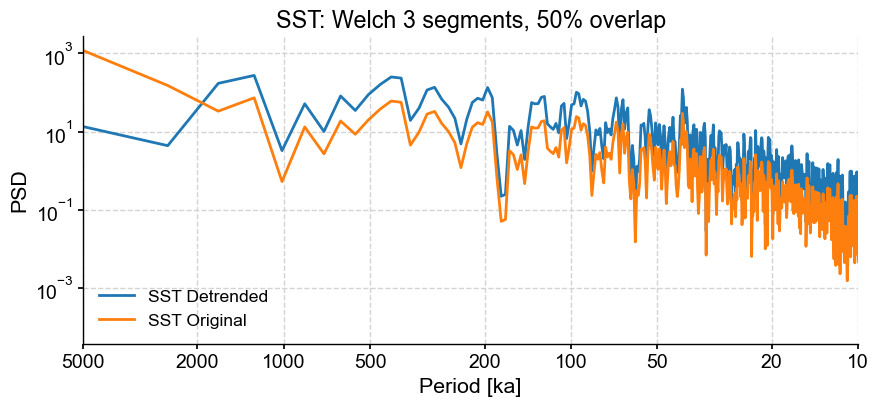

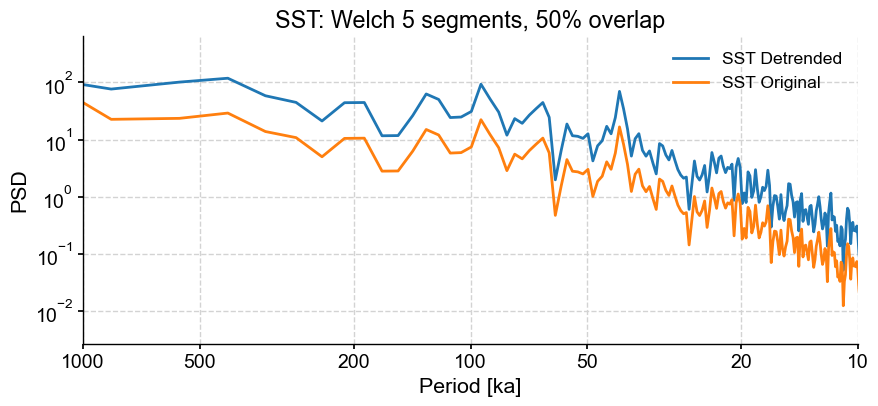

In [214]:
PSD_welch = SSTbin_detrend.standardize().interp().spectral(method='welch')
fig,ax = PSD_welch.plot(label='SST Detrended')
PSD_welch = SSTbin_pyleo.standardize().interp().spectral(method='welch')
PSD_welch.plot(ax = ax, label='SST Original')
ax.set_title('SST: Welch 3 segments, 50% overlap')

PSD_welch = SSTbin_detrend.standardize().interp().spectral(method='welch', 
                                                           settings = {'nperseg':len(SSTbin_detrend.value)/3})
fig,ax = PSD_welch.plot(label='SST Detrended')
PSD_welch = SSTbin_pyleo.standardize().interp().spectral(method='welch', 
                                                         settings = {'nperseg':len(SSTbin_detrend.value)/3})
PSD_welch.plot(ax = ax, label='SST Original')
ax.set_title('SST: Welch 5 segments, 50% overlap')

Text(0.5, 1.0, 'SST Not detrended')

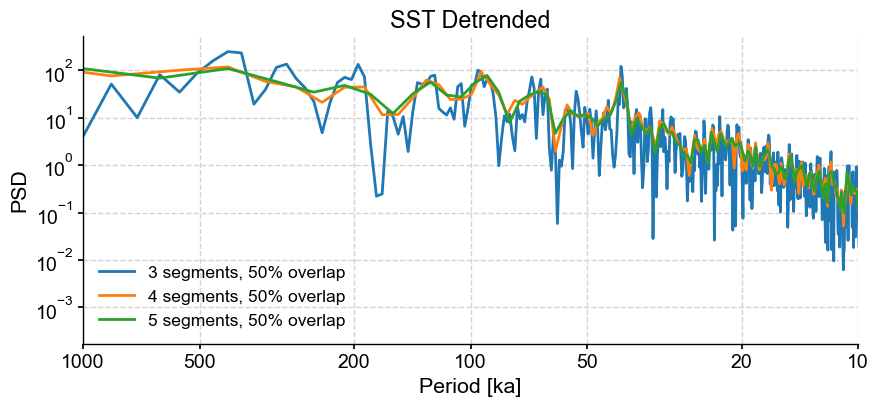

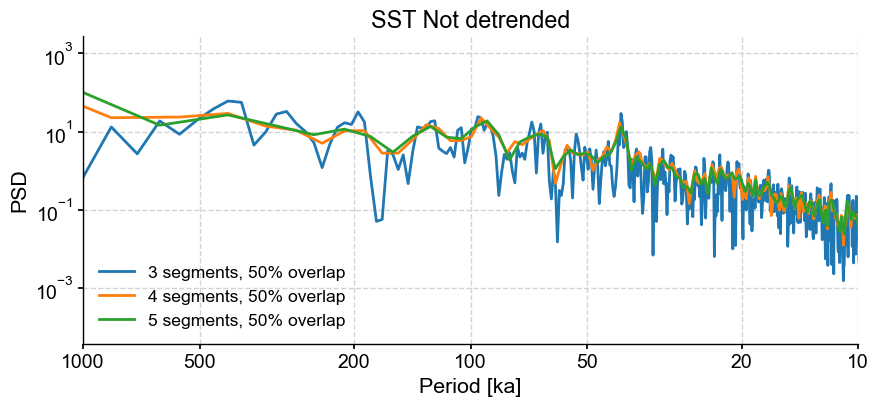

In [160]:
PSD_welch = SSTbin_detrend.standardize().interp().spectral(method='welch')
fig,ax = PSD_welch.plot(label='3 segments, 50% overlap')
SSTbin_detrend.standardize().interp().spectral(method='welch', 
                                               settings = {'nperseg':len(SSTbin_detrend.value)/3}).plot(ax=ax,label='4 segments, 50% overlap')
SSTbin_detrend.standardize().interp().spectral(method='welch', 
                                               settings = {'nperseg':len(SSTbin_detrend.value)/4}).plot(ax=ax,label='5 segments, 50% overlap')
ax.set_title('SST Detrended')

PSD_welch = SSTbin_pyleo.standardize().interp().spectral(method='welch')
fig,ax = PSD_welch.plot(label='3 segments, 50% overlap')
SSTbin_pyleo.standardize().interp().spectral(method='welch', 
                                               settings = {'nperseg':len(SSTbin_pyleo.value)/3}).plot(ax=ax,label='4 segments, 50% overlap')
SSTbin_pyleo.standardize().interp().spectral(method='welch', 
                                               settings = {'nperseg':len(SSTbin_pyleo.value)/4}).plot(ax=ax,label='5 segments, 50% overlap')
ax.set_title('SST Not detrended')

## MTM
> "The most important parameter for MTM is the time-bandwidth product NW, which controls the amount of leakage out of a given spectral line (see. Ghil et al, 2002). This parameter is usually set between 2 and 4 (which is the default for Pyleoclim) in increments of 1/2. 4 is the most conservative choice advocated by MTM’s originator (D. Thomson), though the code allows you to go higher (and therefore, smoother) if you think that is warranted. Let’s have a look at the effect of NW on the spectrum. As NW decreases, the peaks become sharper. This is particularly apparent in the 2000 kyr band (which corresponds to the trend in data; as we will see shortly), whereas the peak corresponding to
is much broader. The trade-off (there always is one in spectral analysis) is that the variance is higher for smaller values of NW (it cannot be seen on this plot, but it means that there is more uncertainty as to the height of a narrow peak than a diffuse one)."
### Comments
Once again, original data shows smaller PSD for nearly all periods except very long periods. Using this method, detrended data shows stronger peaks at orbitally-driven frequencies, as we might expect. Greater values of NW appear to smooth our curve more. As such, NW = 2 shows the most local minima and maxima across nearly all periods. As such, we must determine how much of that is simply noise and how much is meaningful. For this data, since NW=4 shows the orbitally driven periodicities clearly and reduces noise, this may be the safest method that prevents us from interpreting spurious peaks. 

Text(0.5, 1.0, 'SST MTM NW:3.0')

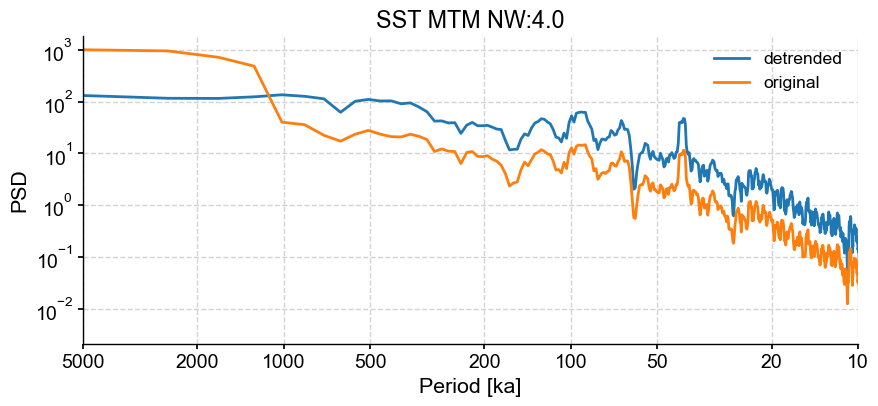

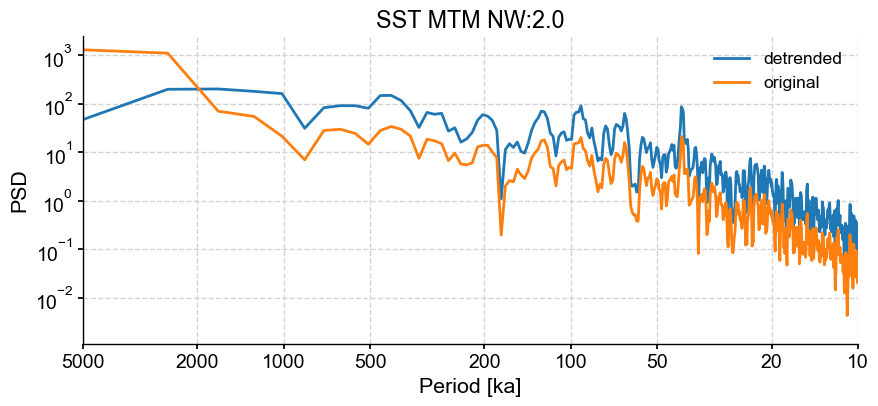

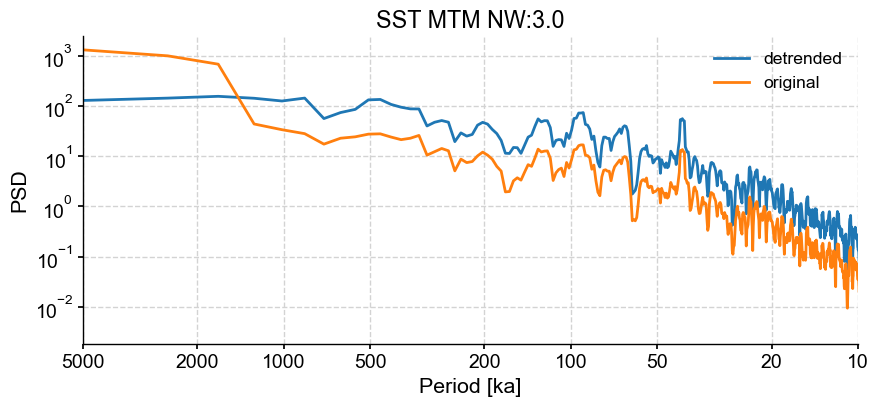

In [142]:
PSD_nw4 = SSTbin_detrend.standardize().interp().spectral(method='mtm')
fig,ax = PSD_nw4.plot(label= 'detrended')
SSTbin_pyleo.standardize().interp().spectral(method='mtm').plot(ax = ax, label = 'original')
ax.set_title('SST MTM NW:4.0')

PSD_nw2 = SSTbin_detrend.standardize().interp().spectral(method='mtm',settings={'NW':2})
fig,ax = PSD_nw2.plot(label= 'detrended')
SSTbin_pyleo.standardize().interp().spectral(method='mtm',settings={'NW':2}).plot(ax = ax, label = 'original')
ax.set_title('SST MTM NW:2.0')

PSD_nw3 = SSTbin_detrend.standardize().interp().spectral(method='mtm',settings={'NW':3})
fig,ax = PSD_nw3.plot(label= 'detrended')
SSTbin_pyleo.standardize().interp().spectral(method='mtm',settings={'NW':3}).plot(ax = ax, label = 'original')
ax.set_title('SST MTM NW:3.0')

Text(0.5, 1.0, 'SST MTM Not Detrended')

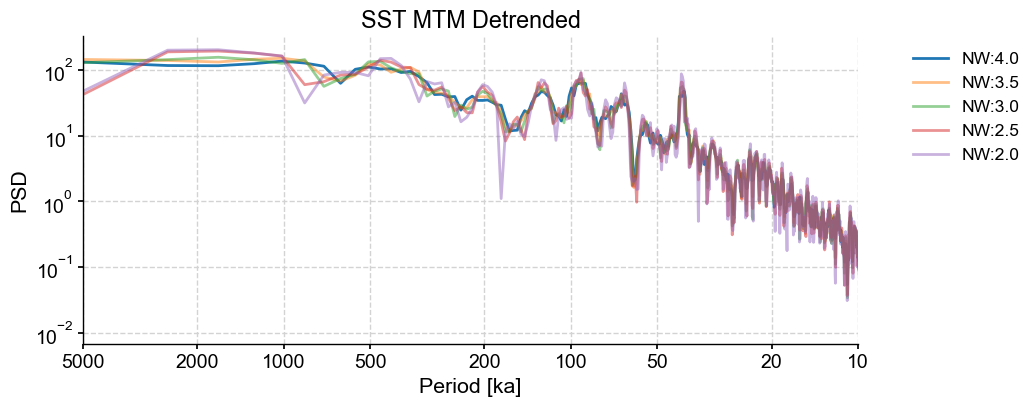

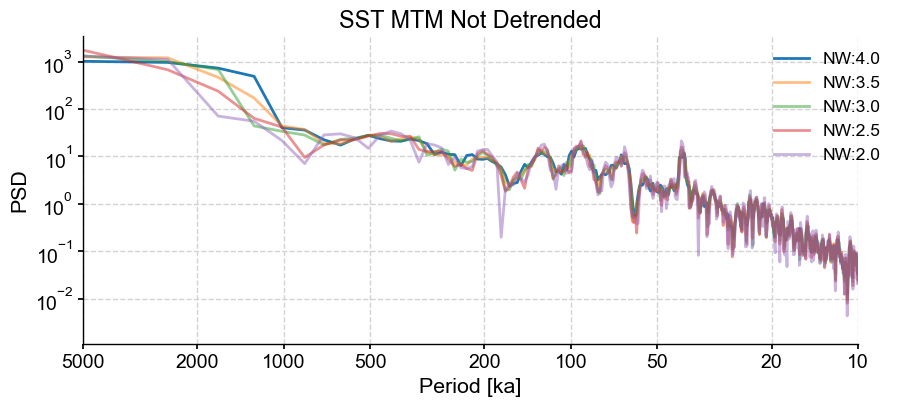

In [143]:
PSD_nw4 = SSTbin_detrend.standardize().interp().spectral(method='mtm')
fig,ax = PSD_nw4.plot(label= 'NW:4.0')
for item in np.flip(np.arange(2,4,0.5)):
    SSTbin_detrend.standardize().interp().spectral(method='mtm', 
                                           settings={'NW':item}).plot(ax=ax, 
                                                                      label = 'NW:'+str(item), 
                                                                      alpha=0.5, 
                                                                      lgd_kwargs={'bbox_to_anchor':(1.05, 1)})
ax.set_title('SST MTM Detrended')

PSD_nw4 = SSTbin_pyleo.standardize().interp().spectral(method='mtm')
fig,ax = PSD_nw4.plot(label= 'NW:4.0')
for item in np.flip(np.arange(2,4,0.5)):
    SSTbin_pyleo.standardize().interp().spectral(method='mtm', 
                                           settings={'NW':item}).plot(ax=ax, 
                                                                      label = 'NW:'+str(item), 
                                                                      alpha=0.5, 
                                                                      lgd_kwargs={'bbox_to_anchor':(1.05, 1)})
ax.set_title('SST MTM Not Detrended')

<AxesSubplot:xlabel='Period [ka]', ylabel='PSD'>

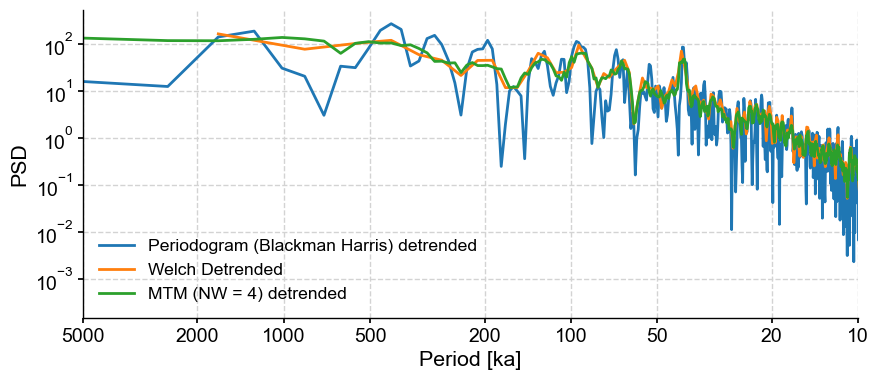

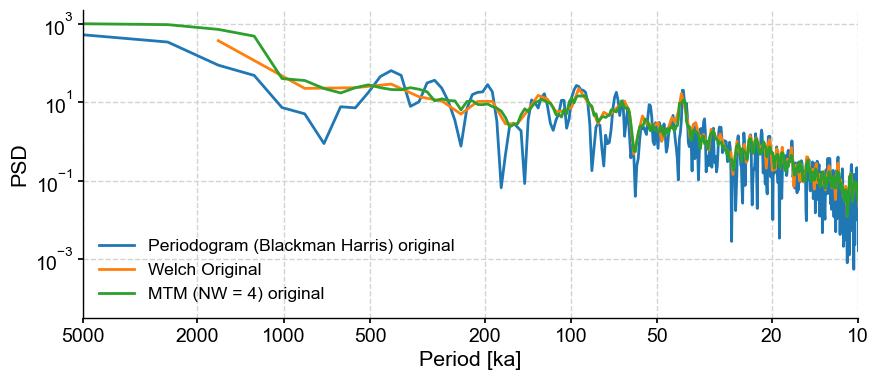

In [107]:
PSD = SSTbin_detrend.standardize().interp().spectral(method='periodogram', settings={'window':'blackmanharris'})
fig,ax = PSD.plot(label = 'Periodogram (Blackman Harris) detrended')
PSD = SSTbin_pyleo.standardize().interp().spectral(method='periodogram', settings={'window':'blackmanharris'})
fig2,ax2 = PSD.plot(label = 'Periodogram (Blackman Harris) original')


PSD_welch = SSTbin_detrend.standardize().interp().spectral(method='welch', 
                                                           settings = {'nperseg':len(SSTbin_detrend.value)/3})
PSD_welch.plot(ax = ax, label='Welch Detrended')
PSD_welch = SSTbin_pyleo.standardize().interp().spectral(method='welch', 
                                                         settings = {'nperseg':len(SSTbin_detrend.value)/3})
PSD_welch.plot(ax = ax2, label='Welch Original')

PSD_nw4 = SSTbin_detrend.standardize().interp().spectral(method='mtm')
PSD_nw4.plot(ax = ax, label= 'MTM (NW = 4) detrended')
SSTbin_pyleo.standardize().interp().spectral(method='mtm').plot(ax = ax2, label = 'MTM (NW = 4) original')


## Lomb Scargle

### `freq`
>"The frequency vector, which can either be user-specified or calculated using different methods `('log','lomb_scargle','welch', 'scale', 'nfft')`, which determines at which points in the frequency domain the periodogram should be computed. This a trade-off: if using too many points, some peaks might be spurious. Not enough, and you can miss some significant periodicities. There is also a computational trade-off here: the more points, the longer it takes for the code to run."

#### Comments
as seen in some of the other methods, detrending the data amplifies the PSD for shorter periods, which in my opinion seems like a good thing. Longer, harder to interpret periodicities aren't watering this signal down.

In terms of freq settings, the lomb scargle appears to give the most granularity, which may lead to spurious signals. However, it does not seem as noisy as some of the previous methods/setting. The alternative freq settings may smooth too much.

Once again, n50 adds a certain amount of smoothing, and I lean more towards n50 = 4.

The differences from different window appear smaller than other variations we have done thus far. 

Text(0.5, 1.0, 'SST Not Detrended')

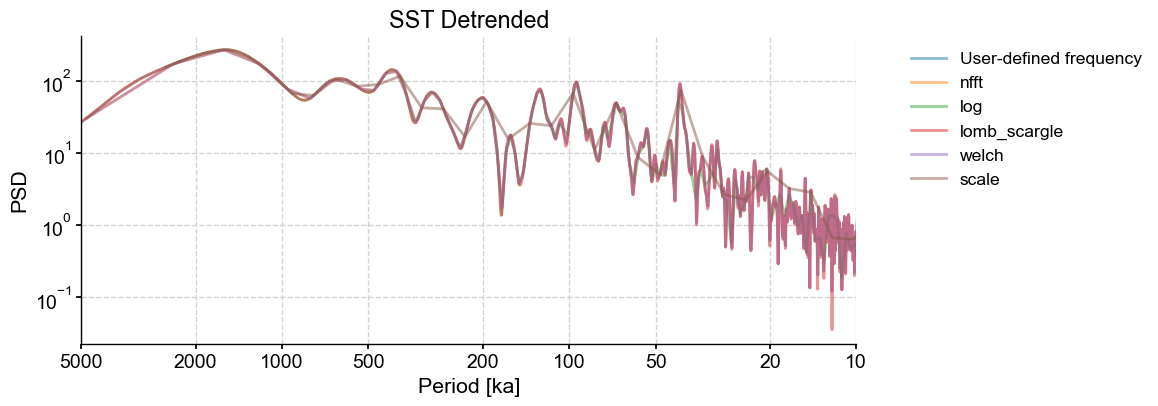

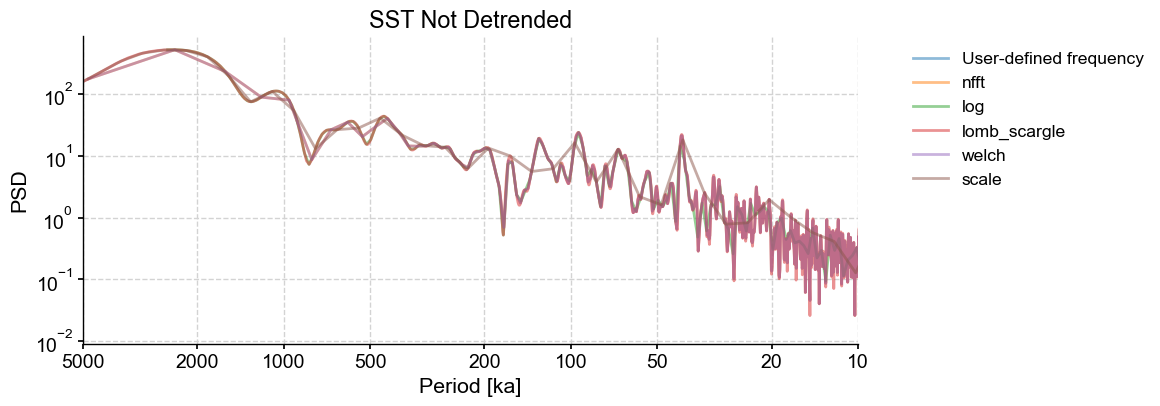

In [215]:
# DETRENDED ********************************************************************************************************************************
freq = np.arange(1/2000,1/5,1/10) # a user defined one to get started. This one should be passed through settings

PSD_ls = SSTbin_detrend.standardize().spectral(method='lomb_scargle', settings={'freq':freq})
fig,ax = PSD_ls.plot(label = 'User-defined frequency',alpha=0.5)

freq_methods = ['nfft','log','lomb_scargle','welch', 'scale']
for freq_method in freq_methods:
    SSTbin_detrend.standardize().spectral(method='lomb_scargle', 
                                  freq_method=freq_method).plot(ax=ax,label=freq_method,alpha=0.5, lgd_kwargs={'bbox_to_anchor':(1.05, 1)})
ax.set_title('SST Detrended')  

# NOT DETRENDED ****************************************************************************************************************************

freq = np.arange(1/2000,1/5,1/10) # a user defined one to get started. This one should be passed through settings

PSD_ls = SSTbin_pyleo.standardize().spectral(method='lomb_scargle', settings={'freq':freq})
fig,ax = PSD_ls.plot(label = 'User-defined frequency',alpha=0.5)

freq_methods = ['nfft','log','lomb_scargle','welch', 'scale']
for freq_method in freq_methods:
    SSTbin_pyleo.standardize().spectral(method='lomb_scargle', 
                                  freq_method=freq_method).plot(ax=ax,label=freq_method,alpha=0.5, lgd_kwargs={'bbox_to_anchor':(1.05, 1)})
ax.set_title('SST Not Detrended')  

### `n50`
> "n50: which determines the number of overlapping segments with 50% overlap using the Welch method"

Text(0.5, 1.0, 'SST Not Detrended')

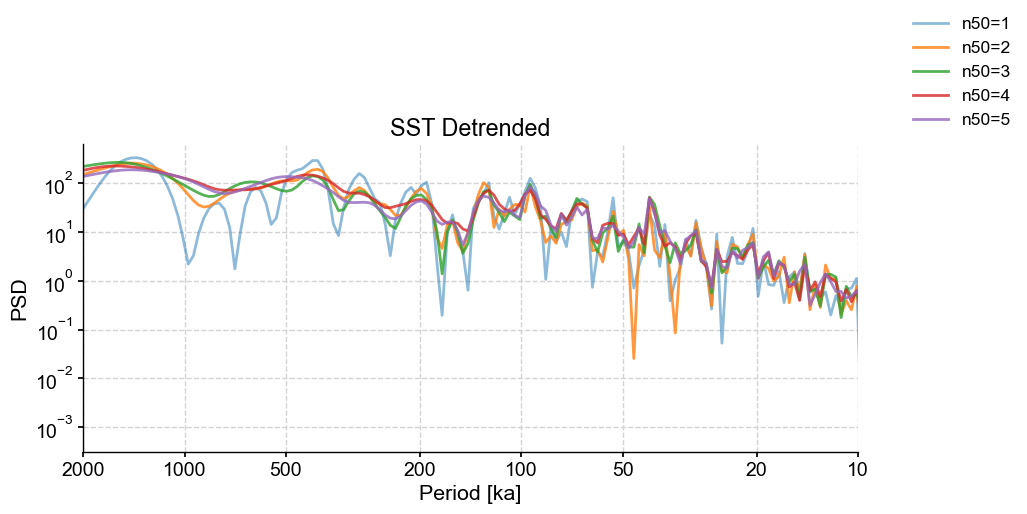

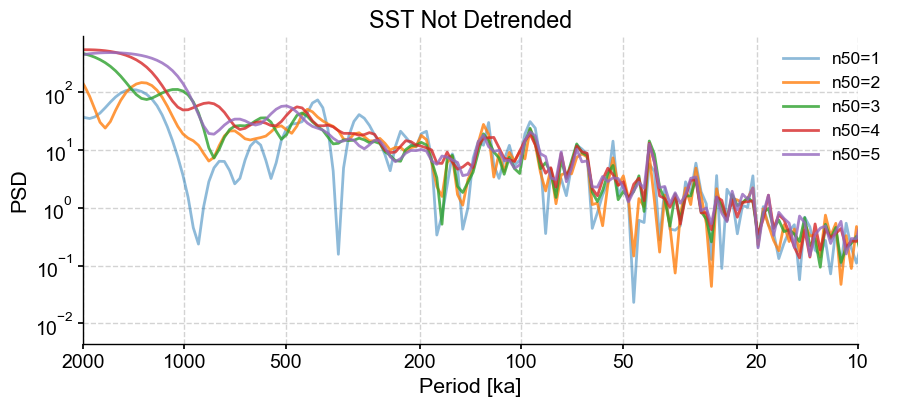

In [216]:
# DETRENDED ********************************************************************************************************************************
PSD_ls = SSTbin_detrend.standardize().spectral(method='lomb_scargle', settings={'n50':1})
fig,ax = PSD_ls.plot(label = 'n50=1',alpha=0.5)

n50s = np.arange(2,6,1)
for item in n50s:
    SSTbin_detrend.standardize().spectral(method='lomb_scargle', 
                                          settings={'n50':item}).plot(ax=ax,
                                                                      label='n50='+str(item),alpha=0.8, 
                                                                      lgd_kwargs={'bbox_to_anchor':(1.05, 1)})
ax.set_title('SST Detrended')  

# NOT DETRENDED ****************************************************************************************************************************
PSD_ls = SSTbin_pyleo.standardize().spectral(method='lomb_scargle', settings={'n50':1})
fig,ax = PSD_ls.plot(label = 'n50=1',alpha=0.5)

n50s = np.arange(2,6,1)
for item in n50s:
    SSTbin_pyleo.standardize().spectral(method='lomb_scargle', 
                                          settings={'n50':item}).plot(ax=ax,
                                                                      label='n50='+str(item),alpha=0.8, 
                                                                      lgd_kwargs={'bbox_to_anchor':(1.05, 1)})
ax.set_title('SST Not Detrended')  

### `window`

Text(0.5, 1.0, 'SST Not Detrended')

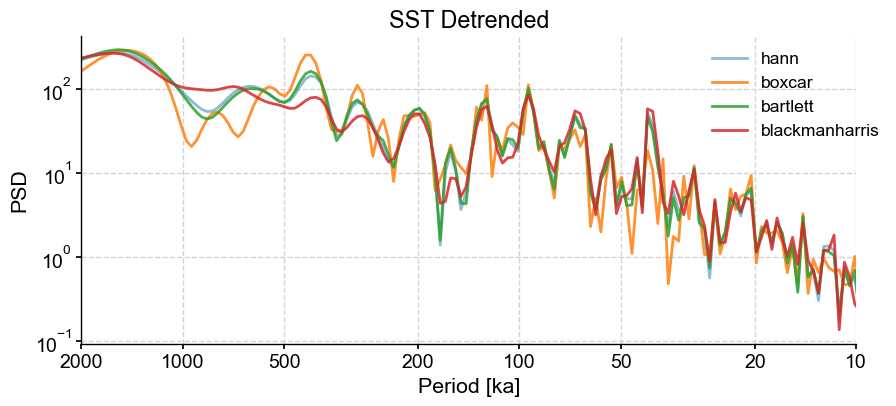

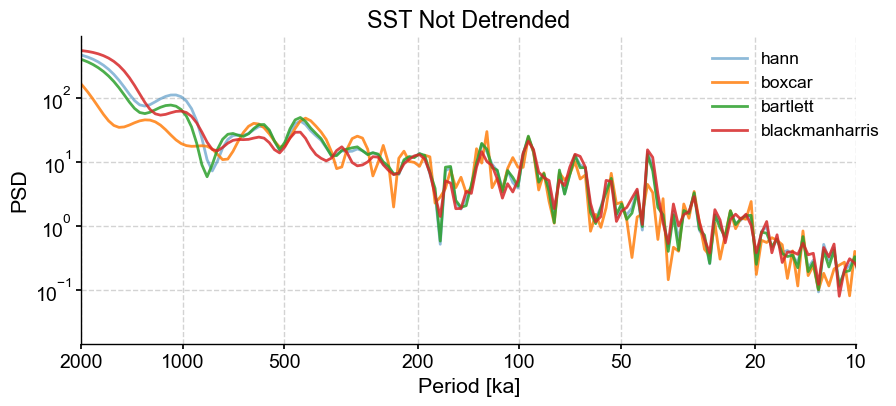

In [217]:
# DETRENDED ********************************************************************************************************************************
window =  ['boxcar', 'bartlett', 'blackmanharris']

PSD_ls = SSTbin_detrend.standardize().spectral()
fig,ax = PSD_ls.plot(label = 'hann',alpha=0.5)

for item in window:
    SSTbin_detrend.standardize().spectral(settings={'window':item}).plot(ax=ax,
                                                                         alpha=0.85,
                                                                         label = item, 
                                                                         lgd_kwargs={'bbox_to_anchor':(1.05, 1)})
ax.set_title('SST Detrended')  

# NOT DETRENDED ****************************************************************************************************************************
window =  ['boxcar', 'bartlett', 'blackmanharris']

PSD_ls = SSTbin_pyleo.standardize().spectral()
fig,ax = PSD_ls.plot(label = 'hann',alpha=0.5)

for item in window:
    SSTbin_pyleo.standardize().spectral(settings={'window':item}).plot(ax=ax,
                                                                         alpha=0.85,
                                                                         label = item, 
                                                                         lgd_kwargs={'bbox_to_anchor':(1.05, 1)})
ax.set_title('SST Not Detrended')  

# Fe and Ca

## Lomb Scargle

I started with the Lomb Scargle method. Since the Ca and Fe data are very noisy at high frequencies compared to the SST data, I set NW = 4 to smooth everything out a bit.

It seems that detrended does not influence CaCO3 and Fe2O3 as much as it influenced SST. 

For SST, we see peaks at 18.5, 20.5, 31, 41, 67, 96, and 125 kyr, among other places. These periods have been marked by gray vertical lines. Many of these align with orbital periodicities. CaCO3 appears to lag behind SST. Consider the SST peaks at 20.5kyr and 41kyr. At these periods, CaCO3 shows a local minimum but soon peaks about 1kyr later.

Fe at higher frequencies/longer periods shows similar peaks in PSD to SST but often of different amplitude. Moreover,the Fe PSD oscillates more frequently. Consider the time period of 18-22kyr. SST shows 2 peaks in PSD at 18.5 and 20.5kyr. Fe shoes peaks at 18.5, 19.5, and 20.5 kyr. In general, an Fe 

In [200]:
ax.get_xlim()

(2000.0, 2.0)

(200.0, 5.0)

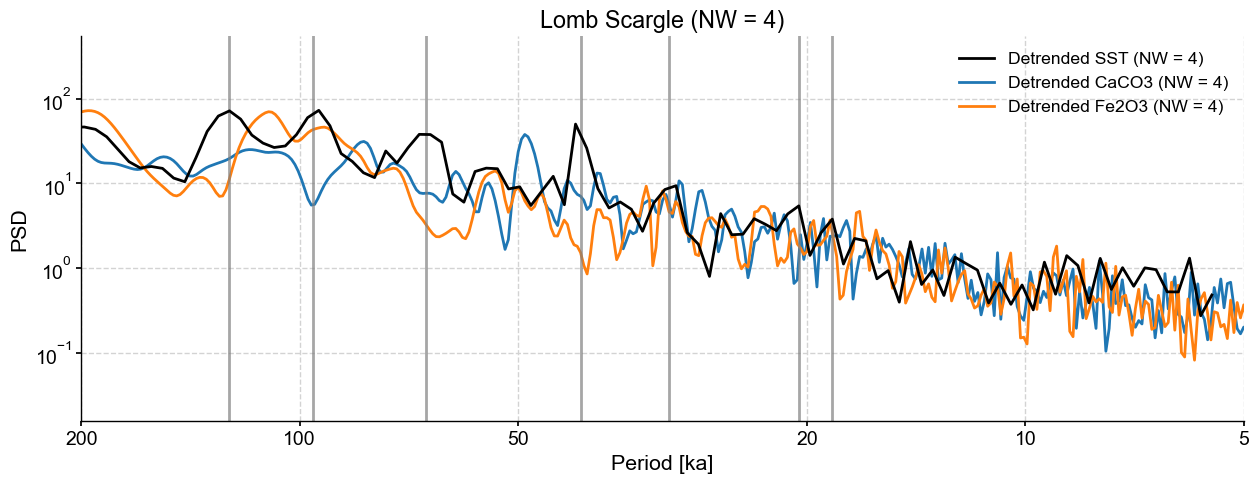

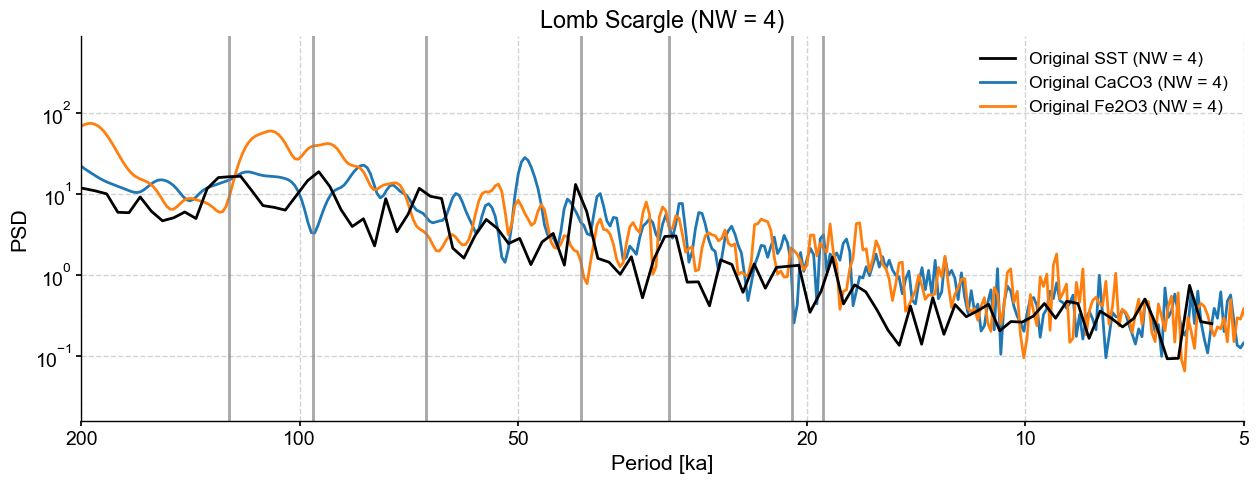

In [218]:
# FIRST PLOT: ax
# SST binned detrended
PSD_ls = SSTbin_detrend.standardize().spectral(method='lomb_scargle', settings={'n50':4})
fig,ax = PSD_ls.plot(color = 'k', zorder = 3, label = 'Detrended SST (NW = 4)', figsize = [15,5])
# CaCO3 binned detrended
PSD_ls = Cabin_detrend.standardize().spectral(method='lomb_scargle', settings={'n50':4})
PSD_ls.plot(ax = ax,label = 'Detrended CaCO3 (NW = 4)')
# Fe2O3 binned detrended
PSD_ls = Febin_detrend.standardize().spectral(method='lomb_scargle', settings={'n50':4})
PSD_ls.plot(ax = ax,label = 'Detrended Fe2O3 (NW = 4)')
# Some annotations and formatting
ax.set_title('Lomb Scargle (NW = 4)')
ax.set_xlim([200,5])
ax.axvline(x = 18.5, color = 'gray', alpha = 0.7)
ax.axvline(x = 20.5, color = 'gray', alpha = 0.7)
ax.axvline(x = 41, color = 'gray', alpha = 0.7)
ax.axvline(x = 96, color = 'gray', alpha = 0.7)
ax.axvline(x = 67, color = 'gray', alpha = 0.7)
ax.axvline(x = 125, color = 'gray', alpha = 0.7)
ax.axvline(x = 31, color = 'gray', alpha = 0.7)

# SECOND PLOT: ax2
# SST binned original
PSD_ls = SSTbin_pyleo.standardize().spectral(method='lomb_scargle', settings={'n50':4})
fig2, ax2 = PSD_ls.plot(color = 'k', zorder = 3, label = 'Original SST (NW = 4)', figsize = [15,5])
# CaCO3 binned original
PSD_ls = Cabin_pyleo.standardize().spectral(method='lomb_scargle',settings={'n50':4})
PSD_ls.plot(ax = ax2, label = 'Original CaCO3 (NW = 4)')
# Fe2O3 binned original
PSD_ls = Febin_pyleo.standardize().spectral(method='lomb_scargle',settings={'n50':4})
PSD_ls.plot(ax = ax2, label = 'Original Fe2O3 (NW = 4)')
# Annotations and formatting
ax2.set_title('Lomb Scargle (NW = 4)')
ax2.axvline(x = 19, color = 'gray', alpha = 0.7)
ax2.axvline(x = 21, color = 'gray', alpha = 0.7)
ax2.axvline(x = 41, color = 'gray', alpha = 0.7)
ax2.axvline(x = 96, color = 'gray', alpha = 0.7)
ax2.axvline(x = 67, color = 'gray', alpha = 0.7)
ax2.axvline(x = 125, color = 'gray', alpha = 0.7)
ax2.axvline(x = 31, color = 'gray', alpha = 0.7)
ax2.set_xlim([200,5])

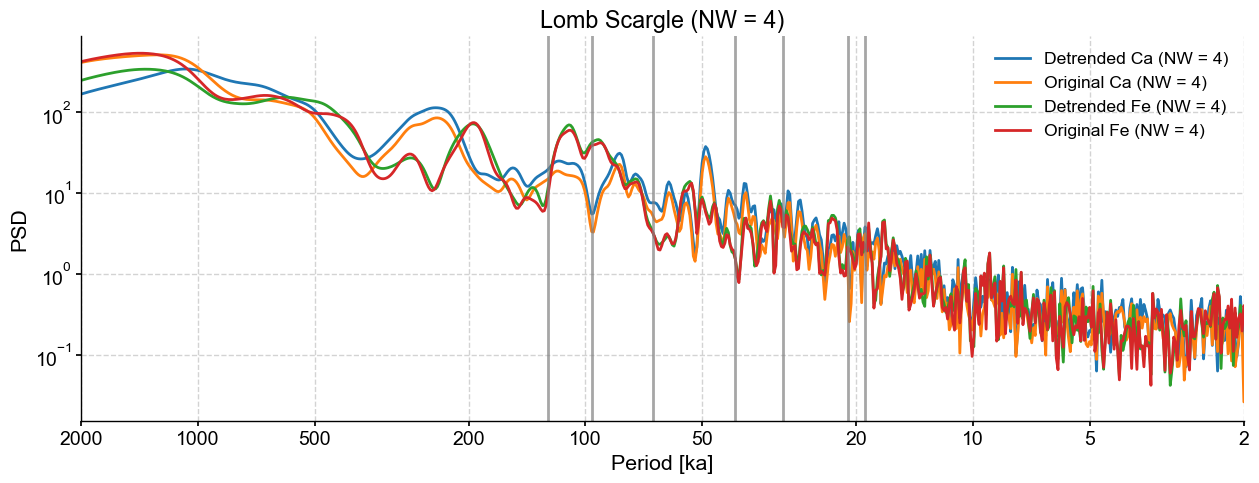

In [219]:
# CaCO3 detrended
PSD_ls = Cabin_detrend.standardize().spectral(method='lomb_scargle', settings={'n50':4})
fig,ax = PSD_ls.plot(label = 'Detrended Ca (NW = 4)', figsize = [15,5])
# CaCO3 
PSD_ls = Cabin_pyleo.standardize().spectral(method='lomb_scargle', settings={'n50':4})
PSD_ls.plot(ax = ax, label = 'Original Ca (NW = 4)')
# Fe2O3 detrended
PSD_ls = Febin_detrend.standardize().spectral(method='lomb_scargle', settings={'n50':4})
PSD_ls.plot(ax = ax, label = 'Detrended Fe (NW = 4)')
# Fe2O3
PSD_ls = Febin_pyleo.standardize().spectral(method='lomb_scargle', settings={'n50':4})
PSD_ls.plot(ax = ax, label = 'Original Fe (NW = 4)')
ax.set_title('Lomb Scargle (NW = 4)')
ax.axvline(x = 19, color = 'gray', alpha = 0.7)
ax.axvline(x = 21, color = 'gray', alpha = 0.7)
ax.axvline(x = 41, color = 'gray', alpha = 0.7)
ax.axvline(x = 96, color = 'gray', alpha = 0.7)
ax.axvline(x = 67, color = 'gray', alpha = 0.7)
ax.axvline(x = 125, color = 'gray', alpha = 0.7)
ax.axvline(x = 31, color = 'gray', alpha = 0.7)



(200.0, 5.0)

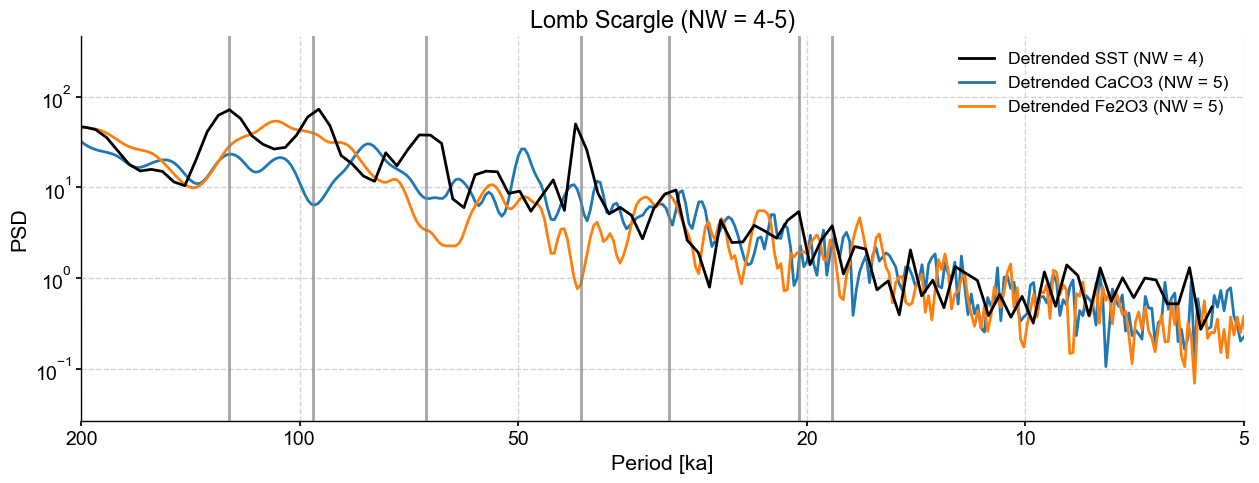

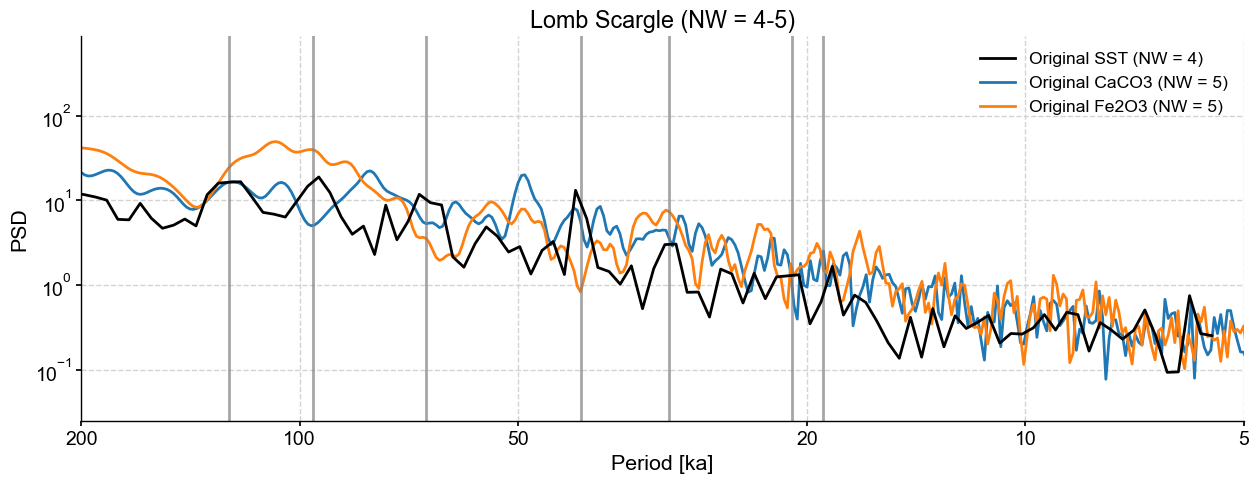

In [220]:
# FIRST PLOT: ax
# SST binned detrended
PSD_ls = SSTbin_detrend.standardize().spectral(method='lomb_scargle', settings={'n50':4})
fig,ax = PSD_ls.plot(color = 'k', zorder = 3, label = 'Detrended SST (NW = 4)', figsize = [15,5])
# CaCO3 binned detrended
PSD_ls = Cabin_detrend.standardize().spectral(method='lomb_scargle', settings={'n50':5})
PSD_ls.plot(ax = ax,label = 'Detrended CaCO3 (NW = 5)')
# Fe2O3 binned detrended
PSD_ls = Febin_detrend.standardize().spectral(method='lomb_scargle', settings={'n50':5})
PSD_ls.plot(ax = ax,label = 'Detrended Fe2O3 (NW = 5)')
# Some annotations and formatting
ax.set_title('Lomb Scargle (NW = 4-5)')
ax.set_xlim([200,5])
ax.axvline(x = 18.5, color = 'gray', alpha = 0.7)
ax.axvline(x = 20.5, color = 'gray', alpha = 0.7)
ax.axvline(x = 41, color = 'gray', alpha = 0.7)
ax.axvline(x = 96, color = 'gray', alpha = 0.7)
ax.axvline(x = 67, color = 'gray', alpha = 0.7)
ax.axvline(x = 125, color = 'gray', alpha = 0.7)
ax.axvline(x = 31, color = 'gray', alpha = 0.7)

# SECOND PLOT: ax2
# SST binned original
PSD_ls = SSTbin_pyleo.standardize().spectral(method='lomb_scargle', settings={'n50':4})
fig2, ax2 = PSD_ls.plot(color = 'k', zorder = 3, label = 'Original SST (NW = 4)', figsize = [15,5])
# CaCO3 binned original
PSD_ls = Cabin_pyleo.standardize().spectral(method='lomb_scargle',settings={'n50':5})
PSD_ls.plot(ax = ax2, label = 'Original CaCO3 (NW = 5)')
# Fe2O3 binned original
PSD_ls = Febin_pyleo.standardize().spectral(method='lomb_scargle',settings={'n50':5})
PSD_ls.plot(ax = ax2, label = 'Original Fe2O3 (NW = 5)')
# Annotations and formatting
ax2.set_title('Lomb Scargle (NW = 4-5)')
ax2.axvline(x = 19, color = 'gray', alpha = 0.7)
ax2.axvline(x = 21, color = 'gray', alpha = 0.7)
ax2.axvline(x = 41, color = 'gray', alpha = 0.7)
ax2.axvline(x = 96, color = 'gray', alpha = 0.7)
ax2.axvline(x = 67, color = 'gray', alpha = 0.7)
ax2.axvline(x = 125, color = 'gray', alpha = 0.7)
ax2.axvline(x = 31, color = 'gray', alpha = 0.7)
ax2.set_xlim([200,5])

## MTM

(200.0, 5.0)

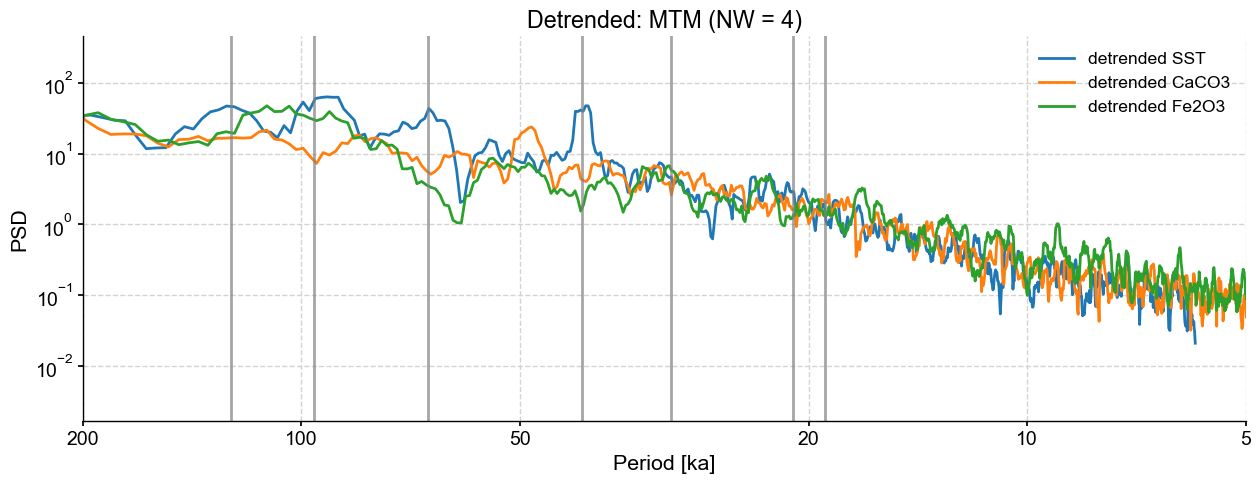

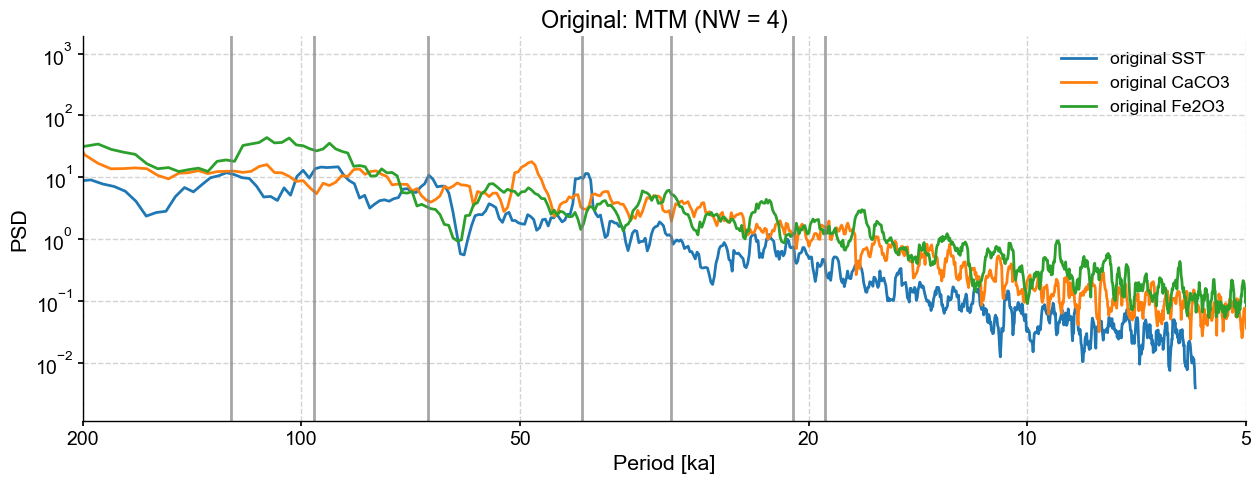

In [221]:
# FIRST PLOT
# SST detrended
PSD_nw4 = SSTbin_detrend.standardize().interp().spectral(method='mtm')
fig,ax = PSD_nw4.plot(label= 'detrended SST', figsize = [15,5])
# CaCO3 detrended
PSD_nw4 = Cabin_detrend.standardize().interp().spectral(method='mtm')
PSD_nw4.plot(ax = ax, label= 'detrended CaCO3')
# Fe2O3 detrended
PSD_nw4 = Febin_detrend.standardize().interp().spectral(method='mtm')
PSD_nw4.plot(ax = ax, label= 'detrended Fe2O3')
# Formatting
ax.set_title('Detrended: MTM (NW = 4)')
ax.axvline(x = 19, color = 'gray', alpha = 0.7)
ax.axvline(x = 21, color = 'gray', alpha = 0.7)
ax.axvline(x = 41, color = 'gray', alpha = 0.7)
ax.axvline(x = 96, color = 'gray', alpha = 0.7)
ax.axvline(x = 67, color = 'gray', alpha = 0.7)
ax.axvline(x = 125, color = 'gray', alpha = 0.7)
ax.axvline(x = 31, color = 'gray', alpha = 0.7)
ax.set_xlim([200,5])

# SECOND PLOT
# SST
PSD_nw4 = SSTbin_pyleo.standardize().interp().spectral(method='mtm')
fig,ax = PSD_nw4.plot(label= 'original SST', figsize = [15,5])
# CaCO3
PSD_nw4 = Cabin_pyleo.standardize().interp().spectral(method='mtm')
PSD_nw4.plot(ax = ax, label= 'original CaCO3')
# Fe2O3
PSD_nw4 = Febin_pyleo.standardize().interp().spectral(method='mtm')
PSD_nw4.plot(ax = ax, label= 'original Fe2O3')
# FOrmatting
ax.set_title('Original: MTM (NW = 4)')
ax.axvline(x = 19, color = 'gray', alpha = 0.7)
ax.axvline(x = 21, color = 'gray', alpha = 0.7)
ax.axvline(x = 41, color = 'gray', alpha = 0.7)
ax.axvline(x = 96, color = 'gray', alpha = 0.7)
ax.axvline(x = 67, color = 'gray', alpha = 0.7)
ax.axvline(x = 125, color = 'gray', alpha = 0.7)
ax.axvline(x = 31, color = 'gray', alpha = 0.7)
ax.set_xlim([200,5])

(200.0, 5.0)

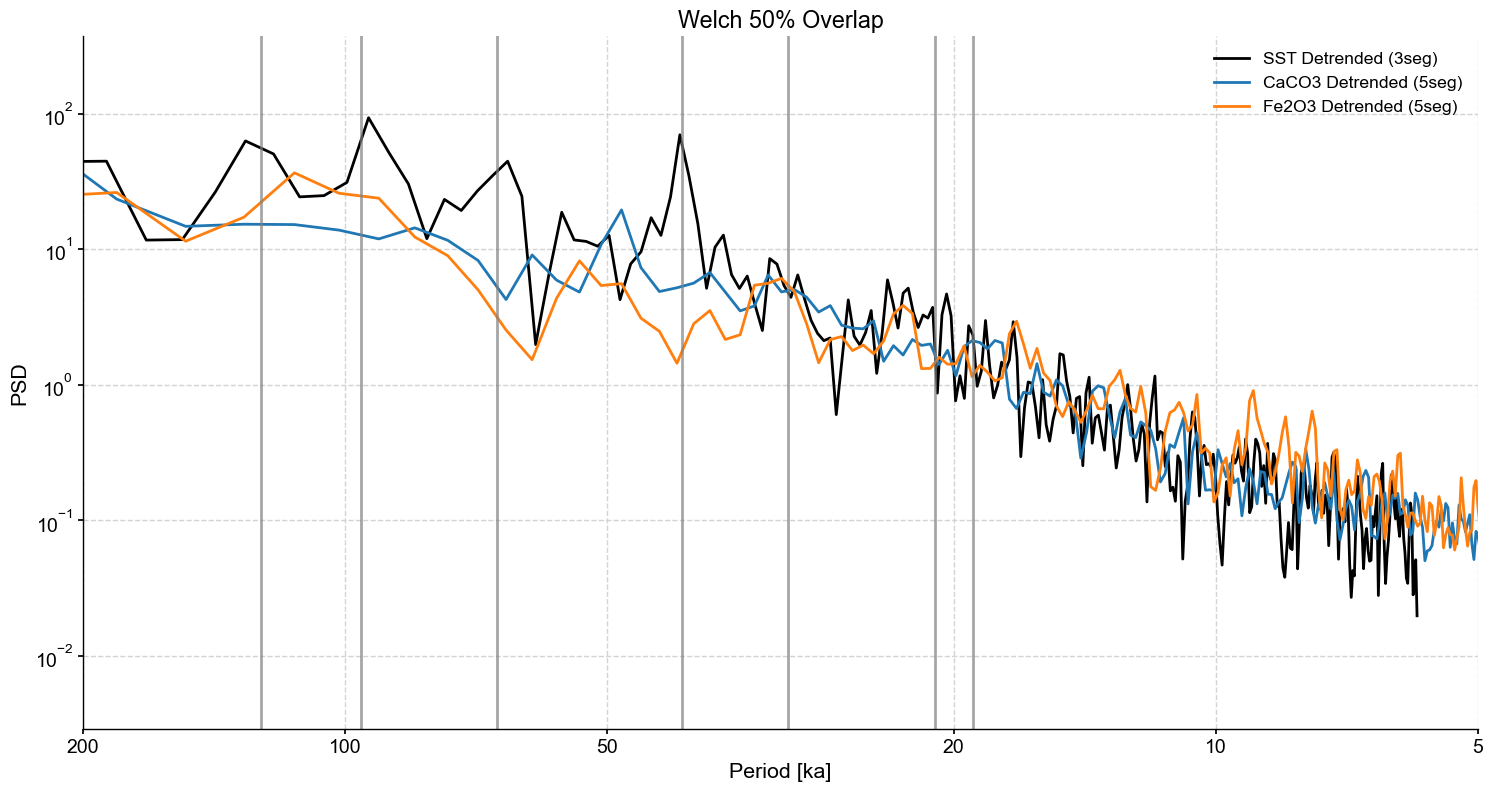

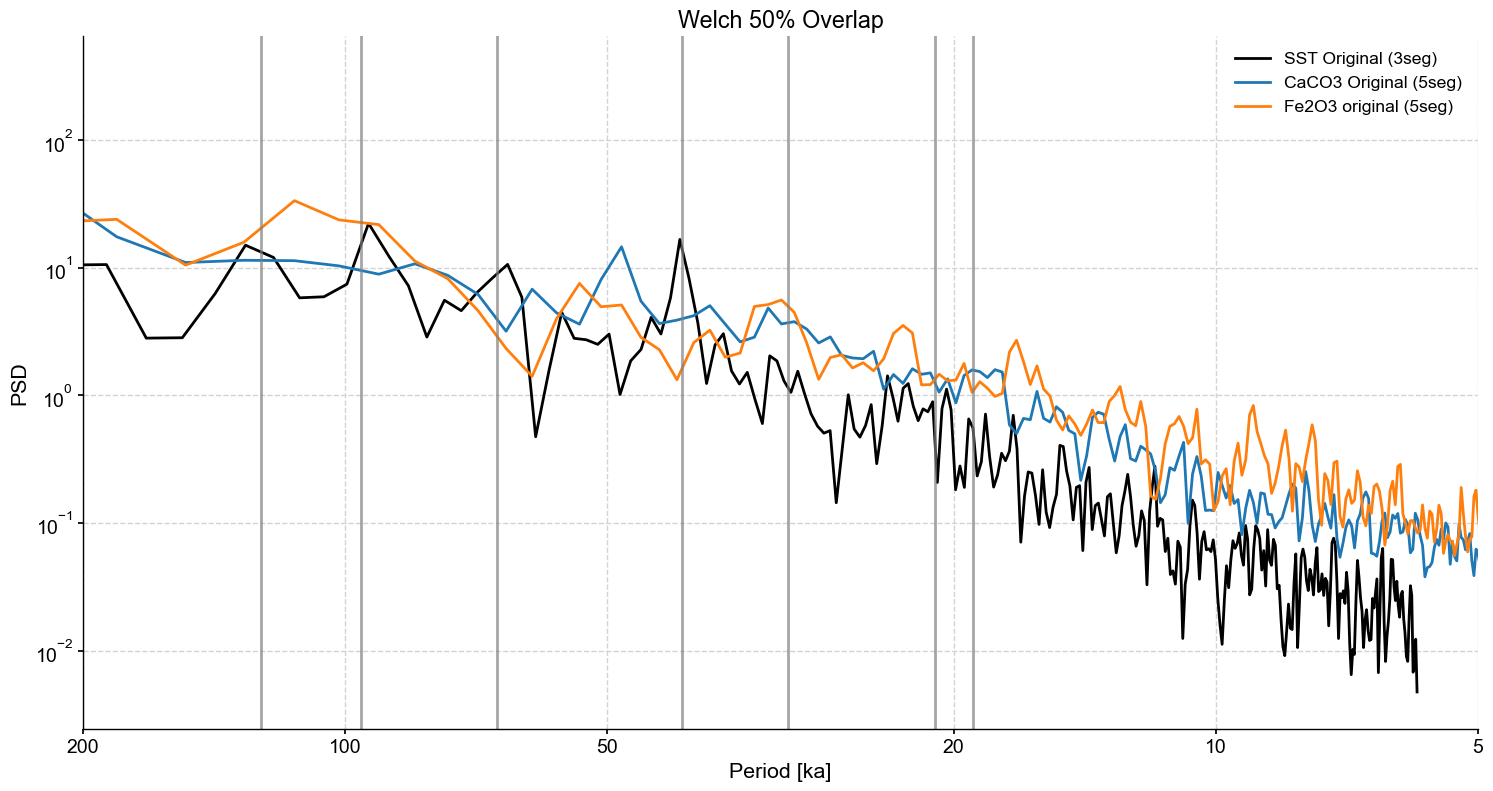

In [223]:
# FIRST PLOT
# SST detrended-3segment
PSD_welch = SSTbin_detrend.standardize().interp().spectral(method='welch', 
                                                           settings = {'nperseg':len(SSTbin_detrend.value)/3})
fig,ax = PSD_welch.plot(color = 'k', label='SST Detrended (3seg)', figsize = [18,9])
# CaCO3 detrended 5 segment
PSD_welch = Cabin_detrend.standardize().interp().spectral(method='welch', 
                                                           settings = {'nperseg':len(Cabin_detrend.value)/5})
PSD_welch.plot(ax = ax, label='CaCO3 Detrended (5seg)')
# Fe2O3 detrended 5 segment
PSD_welch = Febin_detrend.standardize().interp().spectral(method='welch', 
                                                           settings = {'nperseg':len(Febin_detrend.value)/5})
PSD_welch.plot(ax = ax, label='Fe2O3 Detrended (5seg)')
ax.set_title('Welch 50% Overlap')
ax.axvline(x = 19, color = 'gray', alpha = 0.7)
ax.axvline(x = 21, color = 'gray', alpha = 0.7)
ax.axvline(x = 41, color = 'gray', alpha = 0.7)
ax.axvline(x = 96, color = 'gray', alpha = 0.7)
ax.axvline(x = 67, color = 'gray', alpha = 0.7)
ax.axvline(x = 125, color = 'gray', alpha = 0.7)
ax.axvline(x = 31, color = 'gray', alpha = 0.7)
ax.set_xlim([200,5])

# SECOND PLOT
# SST 3 segment
PSD_welch = SSTbin_pyleo.standardize().interp().spectral(method='welch', 
                                                           settings = {'nperseg':len(SSTbin_pyleo.value)/3})

fig,ax = PSD_welch.plot(color = 'k',label='SST Original (3seg)', figsize = [18,9])
# CaCO3 5 segment
PSD_welch = Cabin_pyleo.standardize().interp().spectral(method='welch', 
                                                           settings = {'nperseg':len(Cabin_pyleo.value)/5})
PSD_welch.plot(ax = ax, label='CaCO3 Original (5seg)')
# Fe2O3 5 segment
PSD_welch = Febin_pyleo.standardize().interp().spectral(method='welch', 
                                                           settings = {'nperseg':len(Febin_pyleo.value)/5})
PSD_welch.plot(ax = ax, label='Fe2O3 original (5seg)')
ax.set_title('Welch 50% Overlap')
ax.axvline(x = 19, color = 'gray', alpha = 0.7)
ax.axvline(x = 21, color = 'gray', alpha = 0.7)
ax.axvline(x = 41, color = 'gray', alpha = 0.7)
ax.axvline(x = 96, color = 'gray', alpha = 0.7)
ax.axvline(x = 67, color = 'gray', alpha = 0.7)
ax.axvline(x = 125, color = 'gray', alpha = 0.7)
ax.axvline(x = 31, color = 'gray', alpha = 0.7)
ax.set_xlim([200,5])